In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from utils import *
from keras.applications import ResNet152V2

In [2]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :
val :
test :


In [3]:
n_frames = 2
fc_hidden1 = 512
fc_hidden2 = 256
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

# Create the ResNet50 base model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Create the input layer for the sequence of frames
input_shape = (n_frames, HEIGHT, WIDTH, 3)
input_frames = layers.Input(shape=input_shape)

# Apply the base model to each frame in the sequence
encoded_frames = layers.TimeDistributed(base_model)(input_frames)

# Reshape the encoded frames to match the LSTM input shape
reshaped_frames = layers.Reshape((n_frames, -1))(encoded_frames)

# Apply LSTM layer to process the sequence
x = layers.LSTM(64)(reshaped_frames)

# Add a dense layer for classification
output = layers.Dense(10)(x)

# Create the model
model = keras.Model(input_frames, output)

# Compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 224, 224, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 2, 7, 7, 2048)    58331648  
 ibuted)                                                         
                                                                 
 reshape (Reshape)           (None, 2, 100352)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                25706752  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 84,039,050
Trainable params: 25,707,402
Non-trainable params: 58,331,648
________________________________________

In [4]:
history = model.fit(x = train_ds,
                    epochs = 10, 
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 32s 500ms/step - loss: 1.1434 - accuracy: 0.6667 - val_loss: 0.4308 - val_accuracy: 0.9200
Epoch 2/10
38/38 [==============================] - 14s 381ms/step - loss: 0.2349 - accuracy: 0.9633 - val_loss: 0.2857 - val_accuracy: 0.9500
Epoch 3/10
38/38 [==============================] - 14s 377ms/step - loss: 0.0949 - accuracy: 0.9967 - val_loss: 0.2196 - val_accuracy: 0.9700
Epoch 4/10
38/38 [==============================] - 15s 384ms/step - loss: 0.0612 - accuracy: 0.9967 - val_loss: 0.2152 - val_accuracy: 0.9400
Epoch 5/10
38/38 [==============================] - 14s 379ms/step - loss: 0.0443 - accuracy: 0.9967 - val_loss: 0.2266 - val_accuracy: 0.9600
Epoch 6/10
38/38 [==============================] - 14s 383ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9400
Epoch 7/10
38/38 [==============================] - 14s 379ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.1728 - val_accuracy: 0.9500

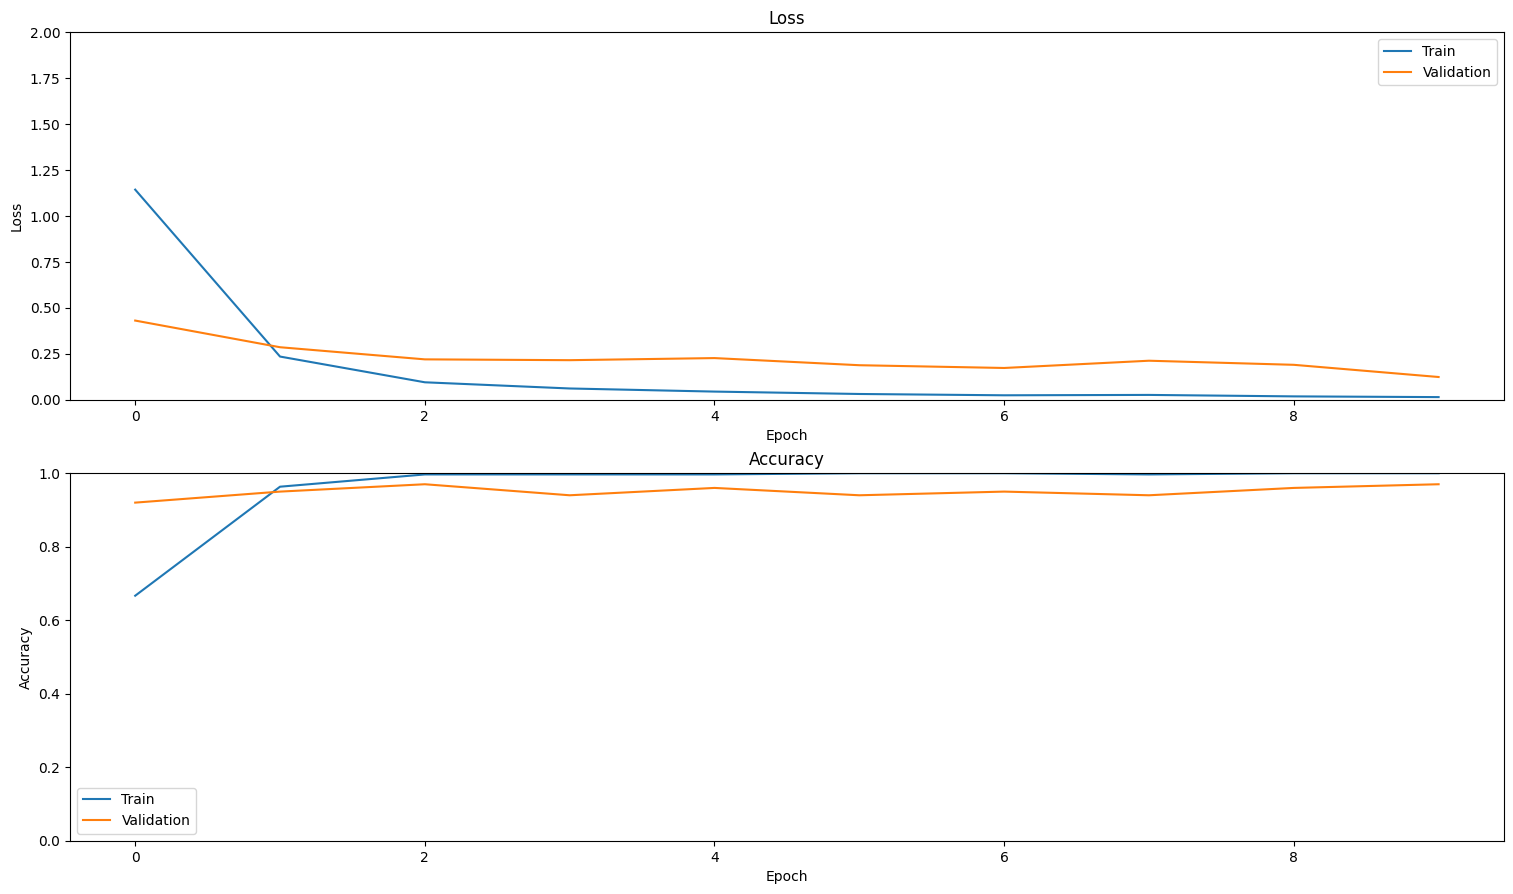

In [5]:
plot_history(history)

In [9]:

model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 4s 266ms/step - loss: 0.1178 - accuracy: 0.9800


{'loss': 0.1177714467048645, 'accuracy': 0.9800000190734863}

13/13 [==============================] - 4s 284ms/step


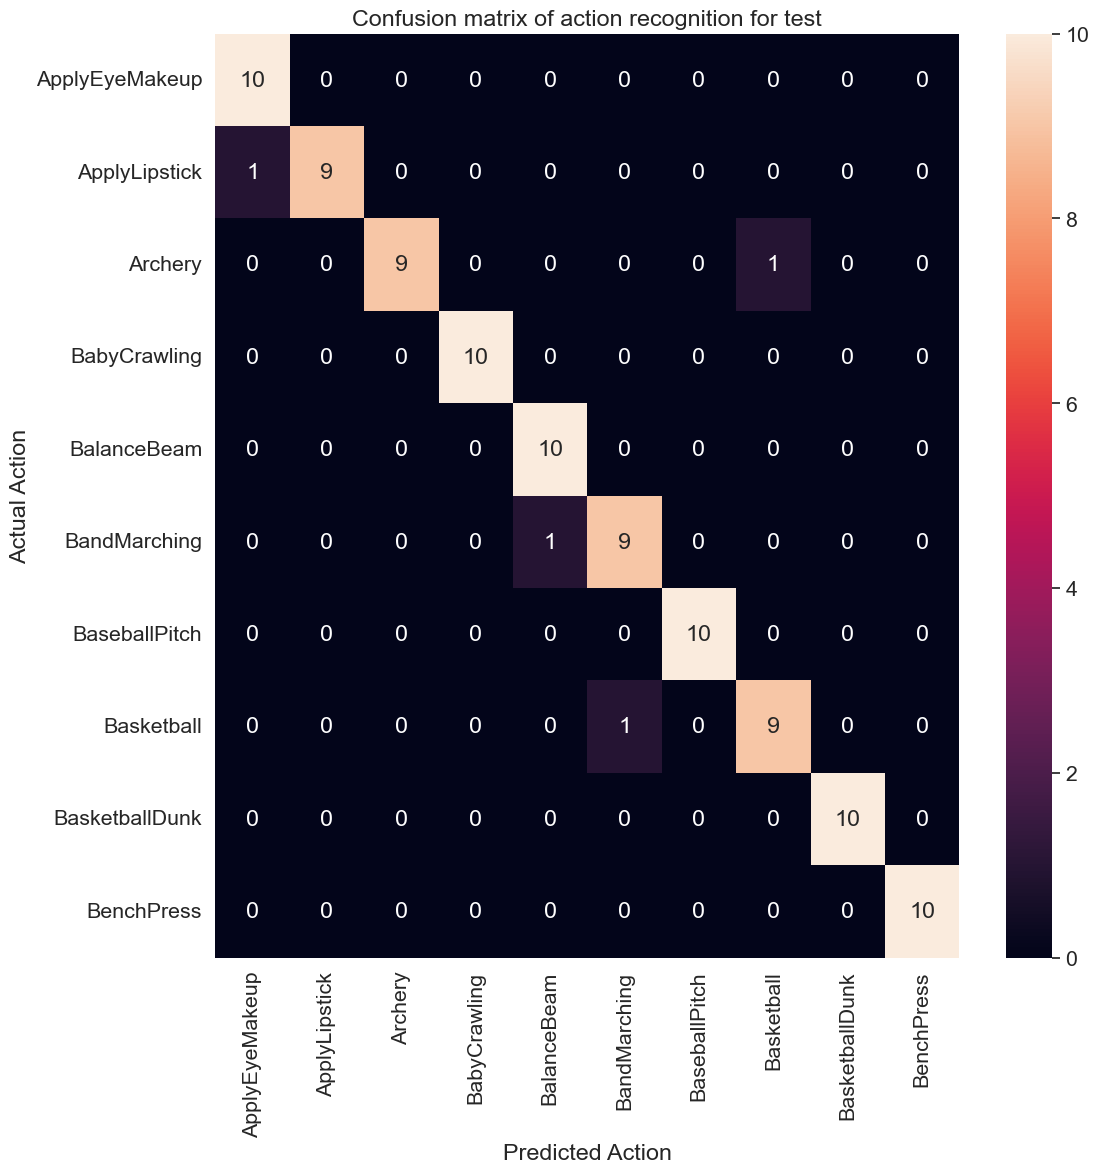

In [8]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')